In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from resnet20 import ResNetCIFAR
# from train_util import train, finetune, test

# Test Model Code

In [ ]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

In [ ]:
# useful libraries
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomCrop(32,4),
     transforms.RandomHorizontalFlip()])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Load Data

In [ ]:
from torch.utils.data import DataLoader


# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
val_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE,
                                          shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=VAL_BATCH_SIZE,
                                         shuffle=False, num_workers=4)
#############################################

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train Model

In [ ]:
# specify the device for computation
#############################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
net = ResNetCIFAR()
net = net.to(device)
!nvidia-smi
#############################################

Run on GPU...
Wed Dec 14 03:43:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   1478MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [ ]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

#############################################
# create loss function
criterion = nn.CrossEntropyLoss() 

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay= REG)
#############################################

==> Training starts!
Epoch 0:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training loss: 1.6888, Training accuracy: 0.3775
Validation loss: 1.4776, Validation accuracy: 0.4507
Saving ...

Epoch 1:
Training loss: 1.2640, Training accuracy: 0.5425
Validation loss: 1.1319, Validation accuracy: 0.6044
Saving ...

Epoch 2:
Training loss: 0.9783, Training accuracy: 0.6519
Validation loss: 1.2998, Validation accuracy: 0.5755

Epoch 3:
Training loss: 0.8158, Training accuracy: 0.7131
Validation loss: 0.8625, Validation accuracy: 0.6984
Saving ...

Epoch 4:
Training loss: 0.7061, Training accuracy: 0.7540
Validation loss: 0.8040, Validation accuracy: 0.7295
Saving ...

Epoch 5:
Training loss: 0.6326, Training accuracy: 0.7808
Validation loss: 0.6326, Validation accuracy: 0.7827
Saving ...

Epoch 6:
Training loss: 0.5756, Training accuracy: 0.8015
Validation loss: 0.6339, Validation accuracy: 0.7927
Saving ...

Epoch 7:
Training loss: 0.5408, Training accuracy: 0.8137
Validation loss: 0.5566, Validation accuracy: 0.8123
Saving ...

Epoch 8:
Training loss: 0.5070, Trai

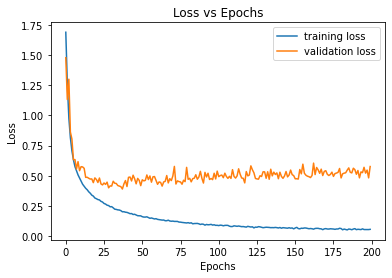

In [ ]:
# some hyperparameters
# total number of training epochs
EPOCHS = 200
# DECAY_EPOCHS = 60
# DECAY = .1
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"
# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR
val_losses = []
train_losses = []

print("==> Training starts!")
print("="*50)
since = time.time()
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    # if i % DECAY_EPOCHS == 0 and i != 0:
    #     current_learning_rate = current_learning_rate * DECAY
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = current_learning_rate
    #     print("Current learning rate has decayed to %f" %current_learning_rate)
    
    #######################
    # switch to train mode
    net.train()
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # copy inputs to device
        inputs, targets = inputs.to(device), targets.to(device)
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()
        correct_examples += correct.item()
        total_examples += outputs.shape[0]
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_losses.append(avg_loss.cpu().detach())
    # Validate on the validation dataset
    net.eval()
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            total_examples += outputs.shape[0]
            correct = predicted.eq(targets).sum()
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    val_losses.append(avg_loss.cpu().detach())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, f'resnet.pth'))
        
    print('')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


plt.plot(np.arange(0,EPOCHS,1), train_losses, label = 'training loss')
plt.plot(np.arange(0,EPOCHS,1), val_losses, label  = 'validation loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# First Bullet Point

In [ ]:
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)
net.load_state_dict(torch.load("./saved_model/resnetBest.pth")['state_dict'])

acc, loss = test_model(net, val_loader, device)
print(f'Model Accuracy WITHOUT Weight Perturbation using Gaussian Noise: {acc}')

for name,layer in net.named_modules():
  if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
    weights = layer.weight

    normal_dist = torch.distributions.Normal(loc=torch.tensor([0.]), scale=torch.tensor([1.0]))
    normal_addition = normal_dist.sample((weights.view(-1).size())).reshape(weights.size()).to(device)

    with torch.no_grad():
      weights.add_(normal_addition * 0.1)
    # weights = layer.weight.cpu().detach().numpy()
    # weights = perturb_weights(weights)

acc, loss = test_model(net, val_loader, device)
print(f'Model Accuracy WITH Weight Perturbation using Gaussian Noise: {acc}')

Model Accuracy WITHOUT Weight Perturbation using Gaussian Noise: 0.8974
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.6768


# Second Bullet Point

==> Training starts!
Epoch 0:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training loss: 2.1992, Training accuracy: 0.2036
Validation loss: 1.9699, Validation accuracy: 0.2297
Saving ...

Epoch 1:
Training loss: 1.9119, Training accuracy: 0.2717
Validation loss: 1.8934, Validation accuracy: 0.2985
Saving ...

Epoch 2:
Training loss: 1.8792, Training accuracy: 0.2927
Validation loss: 1.8539, Validation accuracy: 0.3178
Saving ...

Epoch 3:
Training loss: 1.8531, Training accuracy: 0.3024
Validation loss: 2.4853, Validation accuracy: 0.2702

Epoch 4:
Training loss: 1.8340, Training accuracy: 0.3086
Validation loss: 1.7849, Validation accuracy: 0.3456
Saving ...

Epoch 5:
Training loss: 1.7967, Training accuracy: 0.3260
Validation loss: 1.7906, Validation accuracy: 0.3343

Epoch 6:
Training loss: 1.7709, Training accuracy: 0.3380
Validation loss: 1.7484, Validation accuracy: 0.3488
Saving ...

Epoch 7:
Training loss: 1.7441, Training accuracy: 0.3506
Validation loss: 1.7898, Validation accuracy: 0.3494
Saving ...

Epoch 8:
Training loss: 1.7177, Training accura

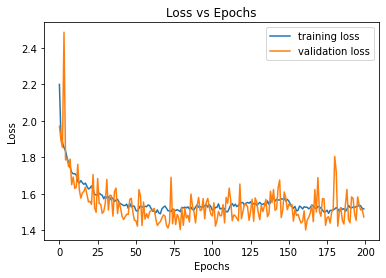

In [ ]:
import torch.nn as nn
import torch.optim as optim


# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

# create loss function
criterion = nn.CrossEntropyLoss() 

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay= REG)
######################################################################################################

# total number of training epochs
EPOCHS = 200

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

train_losses = []
val_losses = []

print("==> Training starts!")
print("="*50)
since = time.time()
for i in range(0, EPOCHS):

    #######################
    # switch to train mode
    net.train()
    #######################
    
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        #################WEIGHT PERTURBATION DURING TRAINING###################

        for name,layer in net.named_modules():
          if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            weights = layer.weight

            normal_dist = torch.distributions.Normal(loc=torch.tensor([0.]), scale=torch.tensor([1.0]))
            normal_addition = normal_dist.sample((weights.view(-1).size())).reshape(weights.size()).to(device)

            with torch.no_grad():
              weights.add_(normal_addition * 0.1)

        #################FORWARD & BACKARD PASSES###################

        # copy inputs to device
        inputs, targets = inputs.to(device), targets.to(device)
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()
        correct_examples += correct.item()
        total_examples += outputs.shape[0]

        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    train_losses.append(avg_loss.cpu().detach())
    # Validate on the validation dataset
    net.eval()
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            total_examples += outputs.shape[0]
            correct = predicted.eq(targets).sum()
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    val_losses.append(avg_loss.cpu().detach())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, f'resnetNaiveNoiseAware.pth'))
        
    print('')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


plt.plot(np.arange(0,EPOCHS,1), train_losses, label = 'training loss')
plt.plot(np.arange(0,EPOCHS,1), val_losses, label  = 'validation loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Third Bullet Point

In [ ]:
#!pip install git+https://github.com/davda54/sam.git
!git clone https://github.com/davda54/sam.git
from sam.sam import SAM

Cloning into 'sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 200 (delta 73), reused 64 (delta 58), pack-reused 104
Receiving objects: 100% (200/200), 659.65 KiB | 6.47 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
import torch.nn as nn
import torch.optim as optim

net = ResNetCIFAR()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

# create loss function
criterion = nn.CrossEntropyLoss() 

# Add optimizer
base_optimizer = optim.SGD#(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay= REG)

# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.1, momentum=0.9)

######################################################################################################

# total number of training epochs
EPOCHS = 200

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
since = time.time()
for i in range(0, EPOCHS):

    #######################
    # switch to train mode
    net.train()
    #######################
    
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        #################FORWARD & BACKARD PASSES###################

        # copy inputs to device
        inputs, targets = inputs.to(device), targets.to(device)
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        #loss = criterion(targets, outputs)  # use this loss for any training statistics
        train_loss += loss
        loss.backward()
        optimizer.first_step(zero_grad=True)

        outputs = net(inputs)
        criterion(outputs, targets).backward()  # make sure to do a full forward pass
        optimizer.second_step(zero_grad=True)

        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()
        correct_examples += correct.item()
        total_examples += outputs.shape[0]

        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    net.eval()
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            total_examples += outputs.shape[0]
            correct = predicted.eq(targets).sum()
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, f'resnetSAM.pth'))
        
    print('')
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training loss: 1.5768, Training accuracy: 0.3941
Validation loss: 1.5053, Validation accuracy: 0.4970
Saving ...

Epoch 1:
Training loss: 1.0837, Training accuracy: 0.5939
Validation loss: 1.0716, Validation accuracy: 0.6247
Saving ...

Epoch 2:
Training loss: 0.8495, Training accuracy: 0.6856
Validation loss: 0.9192, Validation accuracy: 0.6867
Saving ...

Epoch 3:
Training loss: 0.7190, Training accuracy: 0.7330
Validation loss: 0.7434, Validation accuracy: 0.7438
Saving ...

Epoch 4:
Training loss: 0.6412, Training accuracy: 0.7631
Validation loss: 0.6532, Validation accuracy: 0.7718
Saving ...

Epoch 5:
Training loss: 0.5815, Training accuracy: 0.7848
Validation loss: 0.6405, Validation accuracy: 0.7815
Saving ...

Epoch 6:
Training loss: 0.5387, Training accuracy: 0.7984
Validation loss: 0.6269, Validation accuracy: 0.7835
Saving ...

Epoch 7:
Training loss: 0.5053, Training accuracy: 0.8124
Validation loss: 0.5557, Validation accuracy: 0.8091
Saving ...

Epoch 8:
Training loss: 0

# Bonus

==> Training starts!
Epoch 0:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training loss: 1.7738, Training accuracy: 0.3434
Validation loss: 1.4966, Validation accuracy: 0.4377
Saving ...

Epoch 1:
Training loss: 1.3478, Training accuracy: 0.5085
Validation loss: 1.1944, Validation accuracy: 0.5711
Saving ...

Epoch 2:
Training loss: 1.0371, Training accuracy: 0.6293
Validation loss: 0.9799, Validation accuracy: 0.6483
Saving ...

Epoch 3:
Training loss: 0.8689, Training accuracy: 0.6914
Validation loss: 0.8599, Validation accuracy: 0.7080
Saving ...

Epoch 4:
Training loss: 0.7528, Training accuracy: 0.7363
Validation loss: 0.7531, Validation accuracy: 0.7417
Saving ...

Epoch 5:
Training loss: 0.6669, Training accuracy: 0.7684
Validation loss: 0.6686, Validation accuracy: 0.7691
Saving ...

Epoch 6:
Training loss: 0.6070, Training accuracy: 0.7880
Validation loss: 0.6786, Validation accuracy: 0.7715
Saving ...

Epoch 7:
Training loss: 0.5667, Training accuracy: 0.8046
Validation loss: 0.5478, Validation accuracy: 0.8104
Saving ...

Epoch 8:
Training loss: 0

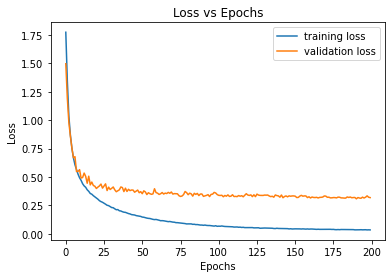

In [ ]:
import torch.nn as nn
import torch.optim as optim

net = ResNetCIFAR()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

# create loss function
criterion = nn.CrossEntropyLoss() 

# Add optimizer
base_optimizer = optim.SGD#(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay= REG)

rho = 0.00
rho_increment = .02
increment_rate = 10 #increment rho every increment_rate epochs

# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.1, momentum=0.9, rho = rho)

######################################################################################################

# total number of training epochs
EPOCHS = 200

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR
train_losses = []
val_losses = []
print("==> Training starts!")
print("="*50)
since = time.time()
for i in range(0, EPOCHS):

    #######################
    # switch to train mode
    net.train()
    #######################
    
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    if (not i == 0) and i % increment_rate == 0:
      rho += rho_increment
      optimizer = SAM(net.parameters(), base_optimizer, lr=0.1, momentum=0.9, rho = rho)
      print(f'Neighborhood Size Increased to {rho}')
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        #################FORWARD & BACKARD PASSES###################

        # copy inputs to device
        inputs, targets = inputs.to(device), targets.to(device)
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        #loss = criterion(targets, outputs)  # use this loss for any training statistics
        train_loss += loss
        loss.backward()
        optimizer.first_step(zero_grad=True)

        outputs = net(inputs)
        criterion(outputs, targets).backward()  # make sure to do a full forward pass
        optimizer.second_step(zero_grad=True)

        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()
        correct_examples += correct.item()
        total_examples += outputs.shape[0]

        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    train_losses.append(avg_loss.cpu().detach())
    # Validate on the validation dataset
    net.eval()
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            total_examples += outputs.shape[0]
            correct = predicted.eq(targets).sum()
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    val_losses.append(avg_loss.cpu().detach())
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, f'resnetMultiStepSAM.pth'))
        
    print('')
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

plt.plot(np.arange(0,EPOCHS,1), train_losses, label = 'training loss')
plt.plot(np.arange(0,EPOCHS,1), val_losses, label  = 'validation loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Perturb Strength: 0.0 

./saved_model/resnetMultiStepSAM.pth


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.9109 

./saved_model/resnetStandard.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.8974 

./saved_model/resnetSAM.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.9026 

./saved_model/resnetNaiveNoiseAware.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.5031 

Perturb Strength: 0.05 

./saved_model/resnetMultiStepSAM.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.9017 

./saved_model/resnetStandard.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.8423 

./saved_model/resnetSAM.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.8852 

./saved_model/resnetNaiveNoiseAware.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.5043 

Perturb Strength: 0.1 

./saved_model/resnetMultiStepSAM.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.8492 

./saved_model/resnetStandard.pth
Mod

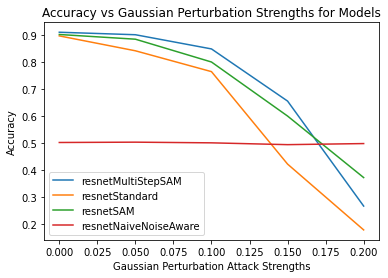

In [ ]:
strengths = np.linspace(0, 0.2, 5)

directory = './saved_model'
acc_dict = dict()

for PERTURB_STRENGTH in strengths:
  print(f'Perturb Strength: {PERTURB_STRENGTH} \n')
  for filename in os.listdir(directory):
      if not filename.split('.')[1] == 'pth':
        continue
      f = os.path.join(directory, filename)
      acc = eval_model_gaussian_perturb(PERTURB_STRENGTH, f)

      accuracies = acc_dict.get(filename, [])
      accuracies.append(acc)
      acc_dict[filename] = accuracies

plt.xlabel('Gaussian Perturbation Attack Strengths')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gaussian Perturbation Strengths for Models')

for key in acc_dict:
  plt.plot(strengths, acc_dict[key], label = key.split('.')[0])

plt.legend()
plt.show()

# Evaluation

In [ ]:
def eval_model_gaussian_perturb(perturb_strength, model_name):
    print(model_name)

    net = ResNetCIFAR(num_layers=20, Nbits=None)
    net = net.to(device)
    net.load_state_dict(torch.load(f'{f}')['state_dict'])

    for name,layer in net.named_modules():
      if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        weights = layer.weight

        normal_dist = torch.distributions.Normal(loc=torch.tensor([0.]), scale=torch.tensor([1.0]))
        normal_addition = normal_dist.sample((weights.view(-1).size())).reshape(weights.size()).to(device)

        with torch.no_grad():
          weights.add_(normal_addition * perturb_strength)

    acc, loss = test_model(net, val_loader, device)
    print(f'Model Accuracy WITH Weight Perturbation using Gaussian Noise: {acc} \n')

    return acc

## Resistance Against Gaussian Weight Perturbation

Perturb Strength: 0.0 

./saved_model/resnetSAM.pth


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.9026 

./saved_model/resnetStandard.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.8974 

./saved_model/resnetNaiveNoiseAware.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.5031 

Perturb Strength: 0.05 

./saved_model/resnetSAM.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.8848 

./saved_model/resnetStandard.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.861 

./saved_model/resnetNaiveNoiseAware.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.5036 

Perturb Strength: 0.1 

./saved_model/resnetSAM.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.7493 

./saved_model/resnetStandard.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.6241 

./saved_model/resnetNaiveNoiseAware.pth
Model Accuracy WITH Weight Perturbation using Gaussian Noise: 0.5004 

Perturb Strength: 0.15000000000000002 

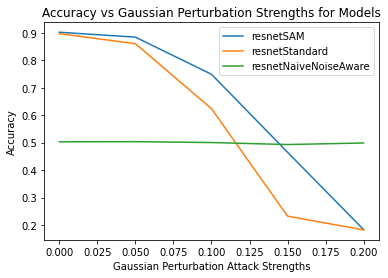

In [ ]:
strengths = np.linspace(0, 0.2, 5)

directory = './saved_model'
acc_dict = dict()

for PERTURB_STRENGTH in strengths:
  print(f'Perturb Strength: {PERTURB_STRENGTH} \n')
  for filename in os.listdir(directory):
      if not filename.split('.')[1] == 'pth':
        continue
      f = os.path.join(directory, filename)
      acc = eval_model_gaussian_perturb(PERTURB_STRENGTH, f)

      accuracies = acc_dict.get(filename, [])
      accuracies.append(acc)
      acc_dict[filename] = accuracies

plt.xlabel('Gaussian Perturbation Attack Strengths')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gaussian Perturbation Strengths for Models')

for key in acc_dict:
  plt.plot(strengths, acc_dict[key], label = key.split('.')[0])

plt.legend()
plt.show()

## Quantization

### Fixed-Point Quantization

resnetMultiStepSAM.pth


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 13.628003339767456, Test Accuracy: 0.1, Nbits: 0
Test Loss: 16.29574680328369, Test Accuracy: 0.0965, Nbits: 2
Test Loss: 1.2789955872297287, Test Accuracy: 0.6463, Nbits: 3
Test Loss: 0.4725725257396698, Test Accuracy: 0.866, Nbits: 4
Test Loss: 0.3423828440904617, Test Accuracy: 0.899, Nbits: 5
Test Loss: 0.3226089529693127, Test Accuracy: 0.9079, Nbits: 6


resnetStandard.pth
Test Loss: 7.211643886566162, Test Accuracy: 0.1, Nbits: 0
Test Loss: 2164.284259033203, Test Accuracy: 0.0994, Nbits: 2
Test Loss: 3.0222370374202727, Test Accuracy: 0.5954, Nbits: 3
Test Loss: 0.7160992234945297, Test Accuracy: 0.848, Nbits: 4
Test Loss: 0.5027942456305027, Test Accuracy: 0.8913, Nbits: 5
Test Loss: 0.4763572458922863, Test Accuracy: 0.8946, Nbits: 6


resnetSAM.pth
Test Loss: 17.04588628768921, Test Accuracy: 0.1, Nbits: 0
Test Loss: 4.312005960941315, Test Accuracy: 0.1096, Nbits: 2
Test Loss: 4.1827392530441285, Test Accuracy: 0.558, Nbits: 3
Test Loss: 0.7375094106793404, Test 

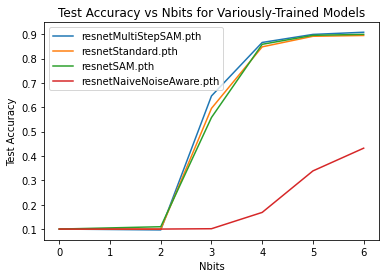

In [ ]:
directory = './saved_model'

for filename in os.listdir(directory):
  if not filename.split('.')[1] == 'pth':
    continue
  f = os.path.join(directory, filename)

  print(filename)

  # Define quantized model and load weight
  #n = [None, 6,5,4,3,2]
  n = [0,2,3,4,5,6]
  accuracies = []
  for Nbits in n:
    
    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    net.load_state_dict(torch.load(f)['state_dict'])
    acc, loss = test_model(net, val_loader, device)
    accuracies.append(acc)
    print(f'Test Loss: {loss}, Test Accuracy: {acc}, Nbits: {Nbits}')

  print('\n')
  plt.plot([0,2,3,4,5,6], accuracies, label = filename)

plt.xlabel('Nbits')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Nbits for Variously-Trained Models')
plt.legend()
plt.show()

### Extra Parsing

In [ ]:
s = '''Training loss: 1.5768, Training accuracy: 0.3941
Validation loss: 1.5053, Validation accuracy: 0.4970
Saving ...

Epoch 1:
Training loss: 1.0837, Training accuracy: 0.5939
Validation loss: 1.0716, Validation accuracy: 0.6247
Saving ...

Epoch 2:
Training loss: 0.8495, Training accuracy: 0.6856
Validation loss: 0.9192, Validation accuracy: 0.6867
Saving ...

Epoch 3:
Training loss: 0.7190, Training accuracy: 0.7330
Validation loss: 0.7434, Validation accuracy: 0.7438
Saving ...

Epoch 4:
Training loss: 0.6412, Training accuracy: 0.7631
Validation loss: 0.6532, Validation accuracy: 0.7718
Saving ...

Epoch 5:
Training loss: 0.5815, Training accuracy: 0.7848
Validation loss: 0.6405, Validation accuracy: 0.7815
Saving ...

Epoch 6:
Training loss: 0.5387, Training accuracy: 0.7984
Validation loss: 0.6269, Validation accuracy: 0.7835
Saving ...

Epoch 7:
Training loss: 0.5053, Training accuracy: 0.8124
Validation loss: 0.5557, Validation accuracy: 0.8091
Saving ...

Epoch 8:
Training loss: 0.4790, Training accuracy: 0.8199
Validation loss: 0.5681, Validation accuracy: 0.8056

Epoch 9:
Training loss: 0.4486, Training accuracy: 0.8327
Validation loss: 0.4921, Validation accuracy: 0.8331
Saving ...

Epoch 10:
Training loss: 0.4277, Training accuracy: 0.8382
Validation loss: 0.4828, Validation accuracy: 0.8350
Saving ...

Epoch 11:
Training loss: 0.4125, Training accuracy: 0.8456
Validation loss: 0.4662, Validation accuracy: 0.8408
Saving ...

Epoch 12:
Training loss: 0.3936, Training accuracy: 0.8515
Validation loss: 0.4545, Validation accuracy: 0.8445
Saving ...

Epoch 13:
Training loss: 0.3763, Training accuracy: 0.8580
Validation loss: 0.4611, Validation accuracy: 0.8412

Epoch 14:
Training loss: 0.3675, Training accuracy: 0.8595
Validation loss: 0.4551, Validation accuracy: 0.8476
Saving ...

Epoch 15:
Training loss: 0.3513, Training accuracy: 0.8663
Validation loss: 0.4190, Validation accuracy: 0.8603
Saving ...

Epoch 16:
Training loss: 0.3401, Training accuracy: 0.8705
Validation loss: 0.4082, Validation accuracy: 0.8597

Epoch 17:
Training loss: 0.3264, Training accuracy: 0.8733
Validation loss: 0.4009, Validation accuracy: 0.8645
Saving ...

Epoch 18:
Training loss: 0.3173, Training accuracy: 0.8769
Validation loss: 0.4161, Validation accuracy: 0.8629

Epoch 19:
Training loss: 0.3071, Training accuracy: 0.8813
Validation loss: 0.4239, Validation accuracy: 0.8613

Epoch 20:
Training loss: 0.2943, Training accuracy: 0.8849
Validation loss: 0.4037, Validation accuracy: 0.8681
Saving ...

Epoch 21:
Training loss: 0.2934, Training accuracy: 0.8868
Validation loss: 0.4128, Validation accuracy: 0.8665

Epoch 22:
Training loss: 0.2812, Training accuracy: 0.8914
Validation loss: 0.4044, Validation accuracy: 0.8651

Epoch 23:
Training loss: 0.2726, Training accuracy: 0.8920
Validation loss: 0.3938, Validation accuracy: 0.8670

Epoch 24:
Training loss: 0.2622, Training accuracy: 0.8963
Validation loss: 0.3983, Validation accuracy: 0.8684
Saving ...

Epoch 25:
Training loss: 0.2604, Training accuracy: 0.8978
Validation loss: 0.3946, Validation accuracy: 0.8724
Saving ...

Epoch 26:
Training loss: 0.2481, Training accuracy: 0.9020
Validation loss: 0.3833, Validation accuracy: 0.8761
Saving ...

Epoch 27:
Training loss: 0.2412, Training accuracy: 0.9033
Validation loss: 0.3850, Validation accuracy: 0.8761

Epoch 28:
Training loss: 0.2372, Training accuracy: 0.9054
Validation loss: 0.3942, Validation accuracy: 0.8693

Epoch 29:
Training loss: 0.2295, Training accuracy: 0.9084
Validation loss: 0.4068, Validation accuracy: 0.8677

Epoch 30:
Training loss: 0.2271, Training accuracy: 0.9086
Validation loss: 0.3687, Validation accuracy: 0.8810
Saving ...

Epoch 31:
Training loss: 0.2206, Training accuracy: 0.9105
Validation loss: 0.3847, Validation accuracy: 0.8761

Epoch 32:
Training loss: 0.2107, Training accuracy: 0.9143
Validation loss: 0.3813, Validation accuracy: 0.8748

Epoch 33:
Training loss: 0.2075, Training accuracy: 0.9170
Validation loss: 0.3800, Validation accuracy: 0.8780

Epoch 34:
Training loss: 0.2015, Training accuracy: 0.9186
Validation loss: 0.3952, Validation accuracy: 0.8761

Epoch 35:
Training loss: 0.1999, Training accuracy: 0.9187
Validation loss: 0.4031, Validation accuracy: 0.8696

Epoch 36:
Training loss: 0.1943, Training accuracy: 0.9194
Validation loss: 0.3839, Validation accuracy: 0.8805

Epoch 37:
Training loss: 0.1883, Training accuracy: 0.9239
Validation loss: 0.4008, Validation accuracy: 0.8750

Epoch 38:
Training loss: 0.1838, Training accuracy: 0.9250
Validation loss: 0.3896, Validation accuracy: 0.8808

Epoch 39:
Training loss: 0.1858, Training accuracy: 0.9225
Validation loss: 0.3976, Validation accuracy: 0.8782

Epoch 40:
Training loss: 0.1774, Training accuracy: 0.9270
Validation loss: 0.3723, Validation accuracy: 0.8843
Saving ...

Epoch 41:
Training loss: 0.1736, Training accuracy: 0.9269
Validation loss: 0.3729, Validation accuracy: 0.8810

Epoch 42:
Training loss: 0.1743, Training accuracy: 0.9274
Validation loss: 0.3842, Validation accuracy: 0.8774

Epoch 43:
Training loss: 0.1711, Training accuracy: 0.9295
Validation loss: 0.3908, Validation accuracy: 0.8793

Epoch 44:
Training loss: 0.1658, Training accuracy: 0.9319
Validation loss: 0.4069, Validation accuracy: 0.8775

Epoch 45:
Training loss: 0.1611, Training accuracy: 0.9321
Validation loss: 0.3933, Validation accuracy: 0.8799

Epoch 46:
Training loss: 0.1570, Training accuracy: 0.9344
Validation loss: 0.3922, Validation accuracy: 0.8832

Epoch 47:
Training loss: 0.1570, Training accuracy: 0.9351
Validation loss: 0.3822, Validation accuracy: 0.8832

Epoch 48:
Training loss: 0.1523, Training accuracy: 0.9352
Validation loss: 0.3911, Validation accuracy: 0.8859
Saving ...

Epoch 49:
Training loss: 0.1471, Training accuracy: 0.9382
Validation loss: 0.4173, Validation accuracy: 0.8761

Epoch 50:
Training loss: 0.1450, Training accuracy: 0.9380
Validation loss: 0.3695, Validation accuracy: 0.8911
Saving ...

Epoch 51:
Training loss: 0.1431, Training accuracy: 0.9394
Validation loss: 0.3775, Validation accuracy: 0.8810

Epoch 52:
Training loss: 0.1385, Training accuracy: 0.9405
Validation loss: 0.3845, Validation accuracy: 0.8839

Epoch 53:
Training loss: 0.1375, Training accuracy: 0.9410
Validation loss: 0.3877, Validation accuracy: 0.8871

Epoch 54:
Training loss: 0.1369, Training accuracy: 0.9393
Validation loss: 0.3776, Validation accuracy: 0.8840

Epoch 55:
Training loss: 0.1328, Training accuracy: 0.9423
Validation loss: 0.3857, Validation accuracy: 0.8876

Epoch 56:
Training loss: 0.1276, Training accuracy: 0.9440
Validation loss: 0.3725, Validation accuracy: 0.8896

Epoch 57:
Training loss: 0.1253, Training accuracy: 0.9452
Validation loss: 0.4010, Validation accuracy: 0.8824

Epoch 58:
Training loss: 0.1249, Training accuracy: 0.9453
Validation loss: 0.3986, Validation accuracy: 0.8825

Epoch 59:
Training loss: 0.1191, Training accuracy: 0.9479
Validation loss: 0.4061, Validation accuracy: 0.8838

Epoch 60:
Training loss: 0.1205, Training accuracy: 0.9467
Validation loss: 0.4136, Validation accuracy: 0.8840

Epoch 61:
Training loss: 0.1200, Training accuracy: 0.9472
Validation loss: 0.3853, Validation accuracy: 0.8879

Epoch 62:
Training loss: 0.1178, Training accuracy: 0.9486
Validation loss: 0.4229, Validation accuracy: 0.8841

Epoch 63:
Training loss: 0.1169, Training accuracy: 0.9481
Validation loss: 0.4182, Validation accuracy: 0.8881

Epoch 64:
Training loss: 0.1114, Training accuracy: 0.9510
Validation loss: 0.3746, Validation accuracy: 0.8913
Saving ...

Epoch 65:
Training loss: 0.1080, Training accuracy: 0.9520
Validation loss: 0.3965, Validation accuracy: 0.8904

Epoch 66:
Training loss: 0.1093, Training accuracy: 0.9521
Validation loss: 0.4004, Validation accuracy: 0.8894

Epoch 67:
Training loss: 0.1089, Training accuracy: 0.9514
Validation loss: 0.4163, Validation accuracy: 0.8868

Epoch 68:
Training loss: 0.1072, Training accuracy: 0.9518
Validation loss: 0.4081, Validation accuracy: 0.8858

Epoch 69:
Training loss: 0.1029, Training accuracy: 0.9533
Validation loss: 0.3950, Validation accuracy: 0.8903

Epoch 70:
Training loss: 0.1031, Training accuracy: 0.9538
Validation loss: 0.4285, Validation accuracy: 0.8841

Epoch 71:
Training loss: 0.0998, Training accuracy: 0.9555
Validation loss: 0.4170, Validation accuracy: 0.8884

Epoch 72:
Training loss: 0.0971, Training accuracy: 0.9566
Validation loss: 0.4248, Validation accuracy: 0.8890

Epoch 73:
Training loss: 0.0982, Training accuracy: 0.9550
Validation loss: 0.4040, Validation accuracy: 0.8899

Epoch 74:
Training loss: 0.0924, Training accuracy: 0.9573
Validation loss: 0.4218, Validation accuracy: 0.8921
Saving ...

Epoch 75:
Training loss: 0.0935, Training accuracy: 0.9572
Validation loss: 0.4094, Validation accuracy: 0.8895

Epoch 76:
Training loss: 0.0936, Training accuracy: 0.9577
Validation loss: 0.4104, Validation accuracy: 0.8894

Epoch 77:
Training loss: 0.0880, Training accuracy: 0.9598
Validation loss: 0.4102, Validation accuracy: 0.8953
Saving ...

Epoch 78:
Training loss: 0.0876, Training accuracy: 0.9585
Validation loss: 0.4377, Validation accuracy: 0.8862

Epoch 79:
Training loss: 0.0892, Training accuracy: 0.9588
Validation loss: 0.4431, Validation accuracy: 0.8831

Epoch 80:
Training loss: 0.0899, Training accuracy: 0.9591
Validation loss: 0.4171, Validation accuracy: 0.8933

Epoch 81:
Training loss: 0.0838, Training accuracy: 0.9615
Validation loss: 0.4056, Validation accuracy: 0.8924

Epoch 82:
Training loss: 0.0838, Training accuracy: 0.9609
Validation loss: 0.4414, Validation accuracy: 0.8875

Epoch 83:
Training loss: 0.0839, Training accuracy: 0.9615
Validation loss: 0.4200, Validation accuracy: 0.8899

Epoch 84:
Training loss: 0.0770, Training accuracy: 0.9632
Validation loss: 0.4090, Validation accuracy: 0.8946

Epoch 85:
Training loss: 0.0788, Training accuracy: 0.9620
Validation loss: 0.4087, Validation accuracy: 0.8933

Epoch 86:
Training loss: 0.0819, Training accuracy: 0.9618
Validation loss: 0.4275, Validation accuracy: 0.8923

Epoch 87:
Training loss: 0.0773, Training accuracy: 0.9630
Validation loss: 0.4298, Validation accuracy: 0.8903

Epoch 88:
Training loss: 0.0755, Training accuracy: 0.9643
Validation loss: 0.4413, Validation accuracy: 0.8902

Epoch 89:
Training loss: 0.0778, Training accuracy: 0.9638
Validation loss: 0.4081, Validation accuracy: 0.8952

Epoch 90:
Training loss: 0.0744, Training accuracy: 0.9640
Validation loss: 0.4246, Validation accuracy: 0.8908

Epoch 91:
Training loss: 0.0761, Training accuracy: 0.9646
Validation loss: 0.4370, Validation accuracy: 0.8878

Epoch 92:
Training loss: 0.0730, Training accuracy: 0.9652
Validation loss: 0.4336, Validation accuracy: 0.8932

Epoch 93:
Training loss: 0.0735, Training accuracy: 0.9654
Validation loss: 0.4436, Validation accuracy: 0.8897

Epoch 94:
Training loss: 0.0722, Training accuracy: 0.9663
Validation loss: 0.4397, Validation accuracy: 0.8911

Epoch 95:
Training loss: 0.0692, Training accuracy: 0.9679
Validation loss: 0.4147, Validation accuracy: 0.8955
Saving ...

Epoch 96:
Training loss: 0.0678, Training accuracy: 0.9668
Validation loss: 0.4551, Validation accuracy: 0.8887

Epoch 97:
Training loss: 0.0693, Training accuracy: 0.9665
Validation loss: 0.4320, Validation accuracy: 0.8925

Epoch 98:
Training loss: 0.0662, Training accuracy: 0.9691
Validation loss: 0.4401, Validation accuracy: 0.8885

Epoch 99:
Training loss: 0.0668, Training accuracy: 0.9681
Validation loss: 0.4363, Validation accuracy: 0.8930

Epoch 100:
Training loss: 0.0660, Training accuracy: 0.9678
Validation loss: 0.4556, Validation accuracy: 0.8889

Epoch 101:
Training loss: 0.0644, Training accuracy: 0.9695
Validation loss: 0.4397, Validation accuracy: 0.8936

Epoch 102:
Training loss: 0.0640, Training accuracy: 0.9691
Validation loss: 0.4334, Validation accuracy: 0.8929

Epoch 103:
Training loss: 0.0617, Training accuracy: 0.9701
Validation loss: 0.4353, Validation accuracy: 0.8944

Epoch 104:
Training loss: 0.0602, Training accuracy: 0.9699
Validation loss: 0.4471, Validation accuracy: 0.8956
Saving ...

Epoch 105:
Training loss: 0.0630, Training accuracy: 0.9691
Validation loss: 0.4587, Validation accuracy: 0.8912

Epoch 106:
Training loss: 0.0591, Training accuracy: 0.9713
Validation loss: 0.4581, Validation accuracy: 0.8942

Epoch 107:
Training loss: 0.0589, Training accuracy: 0.9708
Validation loss: 0.4592, Validation accuracy: 0.8921

Epoch 108:
Training loss: 0.0591, Training accuracy: 0.9710
Validation loss: 0.4335, Validation accuracy: 0.8955

Epoch 109:
Training loss: 0.0561, Training accuracy: 0.9719
Validation loss: 0.4388, Validation accuracy: 0.8954

Epoch 110:
Training loss: 0.0574, Training accuracy: 0.9724
Validation loss: 0.4400, Validation accuracy: 0.8941

Epoch 111:
Training loss: 0.0559, Training accuracy: 0.9719
Validation loss: 0.4574, Validation accuracy: 0.8952

Epoch 112:
Training loss: 0.0567, Training accuracy: 0.9713
Validation loss: 0.4507, Validation accuracy: 0.8909

Epoch 113:
Training loss: 0.0565, Training accuracy: 0.9714
Validation loss: 0.4452, Validation accuracy: 0.8938

Epoch 114:
Training loss: 0.0533, Training accuracy: 0.9739
Validation loss: 0.4526, Validation accuracy: 0.8915

Epoch 115:
Training loss: 0.0562, Training accuracy: 0.9721
Validation loss: 0.4434, Validation accuracy: 0.8921

Epoch 116:
Training loss: 0.0501, Training accuracy: 0.9747
Validation loss: 0.4446, Validation accuracy: 0.8923

Epoch 117:
Training loss: 0.0509, Training accuracy: 0.9750
Validation loss: 0.4710, Validation accuracy: 0.8908

Epoch 118:
Training loss: 0.0508, Training accuracy: 0.9741
Validation loss: 0.4861, Validation accuracy: 0.8906

Epoch 119:
Training loss: 0.0522, Training accuracy: 0.9731
Validation loss: 0.4470, Validation accuracy: 0.8956

Epoch 120:
Training loss: 0.0507, Training accuracy: 0.9747
Validation loss: 0.4759, Validation accuracy: 0.8910

Epoch 121:
Training loss: 0.0501, Training accuracy: 0.9749
Validation loss: 0.4628, Validation accuracy: 0.8935

Epoch 122:
Training loss: 0.0498, Training accuracy: 0.9741
Validation loss: 0.4806, Validation accuracy: 0.8900

Epoch 123:
Training loss: 0.0507, Training accuracy: 0.9748
Validation loss: 0.4460, Validation accuracy: 0.8950

Epoch 124:
Training loss: 0.0488, Training accuracy: 0.9756
Validation loss: 0.4598, Validation accuracy: 0.8916

Epoch 125:
Training loss: 0.0487, Training accuracy: 0.9756
Validation loss: 0.4715, Validation accuracy: 0.8903

Epoch 126:
Training loss: 0.0479, Training accuracy: 0.9753
Validation loss: 0.4556, Validation accuracy: 0.8933

Epoch 127:
Training loss: 0.0454, Training accuracy: 0.9757
Validation loss: 0.4569, Validation accuracy: 0.8961
Saving ...

Epoch 128:
Training loss: 0.0429, Training accuracy: 0.9774
Validation loss: 0.4689, Validation accuracy: 0.8905

Epoch 129:
Training loss: 0.0476, Training accuracy: 0.9754
Validation loss: 0.4576, Validation accuracy: 0.8959

Epoch 130:
Training loss: 0.0444, Training accuracy: 0.9776
Validation loss: 0.4611, Validation accuracy: 0.8933

Epoch 131:
Training loss: 0.0427, Training accuracy: 0.9770
Validation loss: 0.4553, Validation accuracy: 0.8992
Saving ...

Epoch 132:
Training loss: 0.0441, Training accuracy: 0.9773
Validation loss: 0.4588, Validation accuracy: 0.8984

Epoch 133:
Training loss: 0.0442, Training accuracy: 0.9773
Validation loss: 0.4751, Validation accuracy: 0.8936

Epoch 134:
Training loss: 0.0443, Training accuracy: 0.9771
Validation loss: 0.4718, Validation accuracy: 0.8964

Epoch 135:
Training loss: 0.0440, Training accuracy: 0.9771
Validation loss: 0.4602, Validation accuracy: 0.8949

Epoch 136:
Training loss: 0.0435, Training accuracy: 0.9782
Validation loss: 0.4932, Validation accuracy: 0.8937

Epoch 137:
Training loss: 0.0439, Training accuracy: 0.9770
Validation loss: 0.4599, Validation accuracy: 0.8977

Epoch 138:
Training loss: 0.0410, Training accuracy: 0.9791
Validation loss: 0.4713, Validation accuracy: 0.8966

Epoch 139:
Training loss: 0.0400, Training accuracy: 0.9794
Validation loss: 0.4557, Validation accuracy: 0.8981

Epoch 140:
Training loss: 0.0404, Training accuracy: 0.9785
Validation loss: 0.4750, Validation accuracy: 0.8957

Epoch 141:
Training loss: 0.0386, Training accuracy: 0.9798
Validation loss: 0.4746, Validation accuracy: 0.8962

Epoch 142:
Training loss: 0.0413, Training accuracy: 0.9787
Validation loss: 0.4693, Validation accuracy: 0.8921

Epoch 143:
Training loss: 0.0402, Training accuracy: 0.9787
Validation loss: 0.4659, Validation accuracy: 0.8987

Epoch 144:
Training loss: 0.0387, Training accuracy: 0.9792
Validation loss: 0.5064, Validation accuracy: 0.8904

Epoch 145:
Training loss: 0.0357, Training accuracy: 0.9808
Validation loss: 0.4978, Validation accuracy: 0.8933

Epoch 146:
Training loss: 0.0376, Training accuracy: 0.9792
Validation loss: 0.5042, Validation accuracy: 0.8908

Epoch 147:
Training loss: 0.0389, Training accuracy: 0.9787
Validation loss: 0.5095, Validation accuracy: 0.8933

Epoch 148:
Training loss: 0.0387, Training accuracy: 0.9789
Validation loss: 0.4862, Validation accuracy: 0.8926

Epoch 149:
Training loss: 0.0347, Training accuracy: 0.9808
Validation loss: 0.4747, Validation accuracy: 0.8954

Epoch 150:
Training loss: 0.0366, Training accuracy: 0.9798
Validation loss: 0.4826, Validation accuracy: 0.8950

Epoch 151:
Training loss: 0.0368, Training accuracy: 0.9802
Validation loss: 0.4925, Validation accuracy: 0.8937

Epoch 152:
Training loss: 0.0366, Training accuracy: 0.9803
Validation loss: 0.5073, Validation accuracy: 0.8922

Epoch 153:
Training loss: 0.0368, Training accuracy: 0.9802
Validation loss: 0.4705, Validation accuracy: 0.8947

Epoch 154:
Training loss: 0.0377, Training accuracy: 0.9800
Validation loss: 0.4880, Validation accuracy: 0.8967

Epoch 155:
Training loss: 0.0332, Training accuracy: 0.9821
Validation loss: 0.4898, Validation accuracy: 0.8972

Epoch 156:
Training loss: 0.0338, Training accuracy: 0.9814
Validation loss: 0.4950, Validation accuracy: 0.8927

Epoch 157:
Training loss: 0.0342, Training accuracy: 0.9815
Validation loss: 0.4954, Validation accuracy: 0.8952

Epoch 158:
Training loss: 0.0361, Training accuracy: 0.9809
Validation loss: 0.4885, Validation accuracy: 0.8967

Epoch 159:
Training loss: 0.0338, Training accuracy: 0.9815
Validation loss: 0.4822, Validation accuracy: 0.8992

Epoch 160:
Training loss: 0.0347, Training accuracy: 0.9816
Validation loss: 0.5142, Validation accuracy: 0.8912

Epoch 161:
Training loss: 0.0340, Training accuracy: 0.9816
Validation loss: 0.4739, Validation accuracy: 0.8973

Epoch 162:
Training loss: 0.0336, Training accuracy: 0.9810
Validation loss: 0.4983, Validation accuracy: 0.8981

Epoch 163:
Training loss: 0.0333, Training accuracy: 0.9814
Validation loss: 0.4783, Validation accuracy: 0.8980

Epoch 164:
Training loss: 0.0309, Training accuracy: 0.9825
Validation loss: 0.5072, Validation accuracy: 0.8937

Epoch 165:
Training loss: 0.0316, Training accuracy: 0.9825
Validation loss: 0.4878, Validation accuracy: 0.8979

Epoch 166:
Training loss: 0.0331, Training accuracy: 0.9822
Validation loss: 0.4903, Validation accuracy: 0.8945

Epoch 167:
Training loss: 0.0312, Training accuracy: 0.9830
Validation loss: 0.4964, Validation accuracy: 0.8966

Epoch 168:
Training loss: 0.0310, Training accuracy: 0.9828
Validation loss: 0.4939, Validation accuracy: 0.8989

Epoch 169:
Training loss: 0.0309, Training accuracy: 0.9828
Validation loss: 0.4957, Validation accuracy: 0.8984

Epoch 170:
Training loss: 0.0316, Training accuracy: 0.9820
Validation loss: 0.4800, Validation accuracy: 0.8986

Epoch 171:
Training loss: 0.0309, Training accuracy: 0.9830
Validation loss: 0.4712, Validation accuracy: 0.8997
Saving ...

Epoch 172:
Training loss: 0.0318, Training accuracy: 0.9824
Validation loss: 0.5037, Validation accuracy: 0.8954

Epoch 173:
Training loss: 0.0302, Training accuracy: 0.9825
Validation loss: 0.5015, Validation accuracy: 0.8965

Epoch 174:
Training loss: 0.0302, Training accuracy: 0.9828
Validation loss: 0.5025, Validation accuracy: 0.8967

Epoch 175:
Training loss: 0.0289, Training accuracy: 0.9834
Validation loss: 0.4834, Validation accuracy: 0.8980

Epoch 176:
Training loss: 0.0288, Training accuracy: 0.9837
Validation loss: 0.4937, Validation accuracy: 0.8951

Epoch 177:
Training loss: 0.0299, Training accuracy: 0.9827
Validation loss: 0.5093, Validation accuracy: 0.8946

Epoch 178:
Training loss: 0.0322, Training accuracy: 0.9822
Validation loss: 0.5038, Validation accuracy: 0.8970

Epoch 179:
Training loss: 0.0284, Training accuracy: 0.9837
Validation loss: 0.5135, Validation accuracy: 0.8958

Epoch 180:
Training loss: 0.0316, Training accuracy: 0.9829
Validation loss: 0.4789, Validation accuracy: 0.8995

Epoch 181:
Training loss: 0.0291, Training accuracy: 0.9834
Validation loss: 0.4902, Validation accuracy: 0.8982

Epoch 182:
Training loss: 0.0288, Training accuracy: 0.9836
Validation loss: 0.5212, Validation accuracy: 0.8910

Epoch 183:
Training loss: 0.0282, Training accuracy: 0.9839
Validation loss: 0.5065, Validation accuracy: 0.8970

Epoch 184:
Training loss: 0.0281, Training accuracy: 0.9839
Validation loss: 0.4921, Validation accuracy: 0.8961

Epoch 185:
Training loss: 0.0288, Training accuracy: 0.9839
Validation loss: 0.4874, Validation accuracy: 0.8997

Epoch 186:
Training loss: 0.0264, Training accuracy: 0.9844
Validation loss: 0.5308, Validation accuracy: 0.8914

Epoch 187:
Training loss: 0.0280, Training accuracy: 0.9839
Validation loss: 0.4965, Validation accuracy: 0.8954

Epoch 188:
Training loss: 0.0283, Training accuracy: 0.9838
Validation loss: 0.5121, Validation accuracy: 0.8928

Epoch 189:
Training loss: 0.0269, Training accuracy: 0.9845
Validation loss: 0.5135, Validation accuracy: 0.8954

Epoch 190:
Training loss: 0.0251, Training accuracy: 0.9852
Validation loss: 0.4947, Validation accuracy: 0.8996

Epoch 191:
Training loss: 0.0249, Training accuracy: 0.9856
Validation loss: 0.5244, Validation accuracy: 0.8922

Epoch 192:
Training loss: 0.0265, Training accuracy: 0.9847
Validation loss: 0.5126, Validation accuracy: 0.8972

Epoch 193:
Training loss: 0.0256, Training accuracy: 0.9848
Validation loss: 0.5160, Validation accuracy: 0.8953

Epoch 194:
Training loss: 0.0259, Training accuracy: 0.9846
Validation loss: 0.5147, Validation accuracy: 0.8980

Epoch 195:
Training loss: 0.0254, Training accuracy: 0.9853
Validation loss: 0.5087, Validation accuracy: 0.8970

Epoch 196:
Training loss: 0.0241, Training accuracy: 0.9862
Validation loss: 0.5258, Validation accuracy: 0.8981

Epoch 197:
Training loss: 0.0253, Training accuracy: 0.9851
Validation loss: 0.4944, Validation accuracy: 0.9026
Saving ...

Epoch 198:
Training loss: 0.0236, Training accuracy: 0.9856
Validation loss: 0.5065, Validation accuracy: 0.8958

Epoch 199:
Training loss: 0.0249, Training accuracy: 0.9857
Validation loss: 0.5208, Validation accuracy: 0.8973'''

a = s.split('Validation loss: ')
b = s.split('Training loss: ')
print(b)

['', '1.5768, Training accuracy: 0.3941\nValidation loss: 1.5053, Validation accuracy: 0.4970\nSaving ...\n\nEpoch 1:\n', '1.0837, Training accuracy: 0.5939\nValidation loss: 1.0716, Validation accuracy: 0.6247\nSaving ...\n\nEpoch 2:\n', '0.8495, Training accuracy: 0.6856\nValidation loss: 0.9192, Validation accuracy: 0.6867\nSaving ...\n\nEpoch 3:\n', '0.7190, Training accuracy: 0.7330\nValidation loss: 0.7434, Validation accuracy: 0.7438\nSaving ...\n\nEpoch 4:\n', '0.6412, Training accuracy: 0.7631\nValidation loss: 0.6532, Validation accuracy: 0.7718\nSaving ...\n\nEpoch 5:\n', '0.5815, Training accuracy: 0.7848\nValidation loss: 0.6405, Validation accuracy: 0.7815\nSaving ...\n\nEpoch 6:\n', '0.5387, Training accuracy: 0.7984\nValidation loss: 0.6269, Validation accuracy: 0.7835\nSaving ...\n\nEpoch 7:\n', '0.5053, Training accuracy: 0.8124\nValidation loss: 0.5557, Validation accuracy: 0.8091\nSaving ...\n\nEpoch 8:\n', '0.4790, Training accuracy: 0.8199\nValidation loss: 0.5681

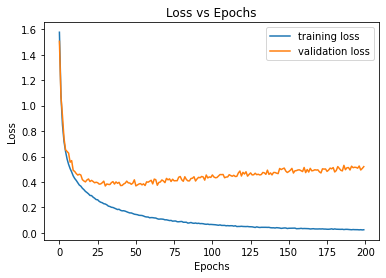

In [ ]:
EPOCHS = 200

validations = []
trains = []
for item in a:
  if item == a[0]:
    continue

  val = item[0:item.find(',')]
  val = float(val)
  validations.append(val)

for item in b:
  if item == b[0]:
    continue

  val = item[0:item.find(',')]
  val = float(val)
  trains.append(val)


plt.plot(np.arange(0,EPOCHS,1), trains, label = 'training loss')
plt.plot(np.arange(0,EPOCHS,1), validations, label  = 'validation loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()